# HW1: KNN Classification

> Name: Liujia Yu
> 
> Github Username: LesleyYu
> 
> USC ID: 4764432021

## a) Resource Downloading
The dataset is stored in folder `vertebral_column_data`

This Biomedical data set was built by Dr. Henrique da Mota during a medical residence period in Lyon, France. Each patient in the data set is represented in the data set by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is used for the class labels: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO) and Abnormal (AB). In this exercise, we only focus on a binary classiﬁcation task NO=0 and AB=1.

In [2]:
# import python libraries
import pandas as pd
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import mahalanobis
import matplotlib
print(matplotlib.__version__)   # ensure the version for matplotlib is 3.9

3.9.2


In [3]:
# load the data set using ARFF file
data, meta = arff.loadarff('../../data/vertebral_column_data/column_2C_weka.arff')
# convert to pandas DataFrame
df = pd.DataFrame(data)

# Decode byte strings to regular strings
df = df.astype({col: str for col in df.select_dtypes(include=['object']).columns})

# map Normal and Abnormal into Integer 0 and 1
df['class'] = df['class'].map({"Normal": 0, "Abnormal": 1})
df['class'] = df['class'].astype(int)

df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0


## b) Pre-Processing and Exploratory data analysis


In [4]:
# check
print(df['class'].unique())
print(len(df["pelvic_incidence"].unique()))     # 310 unique pelvic_incidence values
print(df.dtypes)

# divide the dataset into subsets with diff classes
subset_0 = df[df['class'] == 0]
subset_1 = df[df['class'] == 1]

# Stores lowest training error for Question f
global BTE_Globel   # Global Best Training Error

[1 0]
310
pelvic_incidence            float64
pelvic_tilt                 float64
lumbar_lordosis_angle       float64
sacral_slope                float64
pelvic_radius               float64
degree_spondylolisthesis    float64
class                         int64
dtype: object


#### i) Below is the code that generates *scatterplots* of independent variables in the dataset

Make scatterplots of the independent variables in the dataset. Use color to show Classes 0 and 1.

I am not sure whether to include diagonal plots in scatterplot. Eventually, I got rid of it.

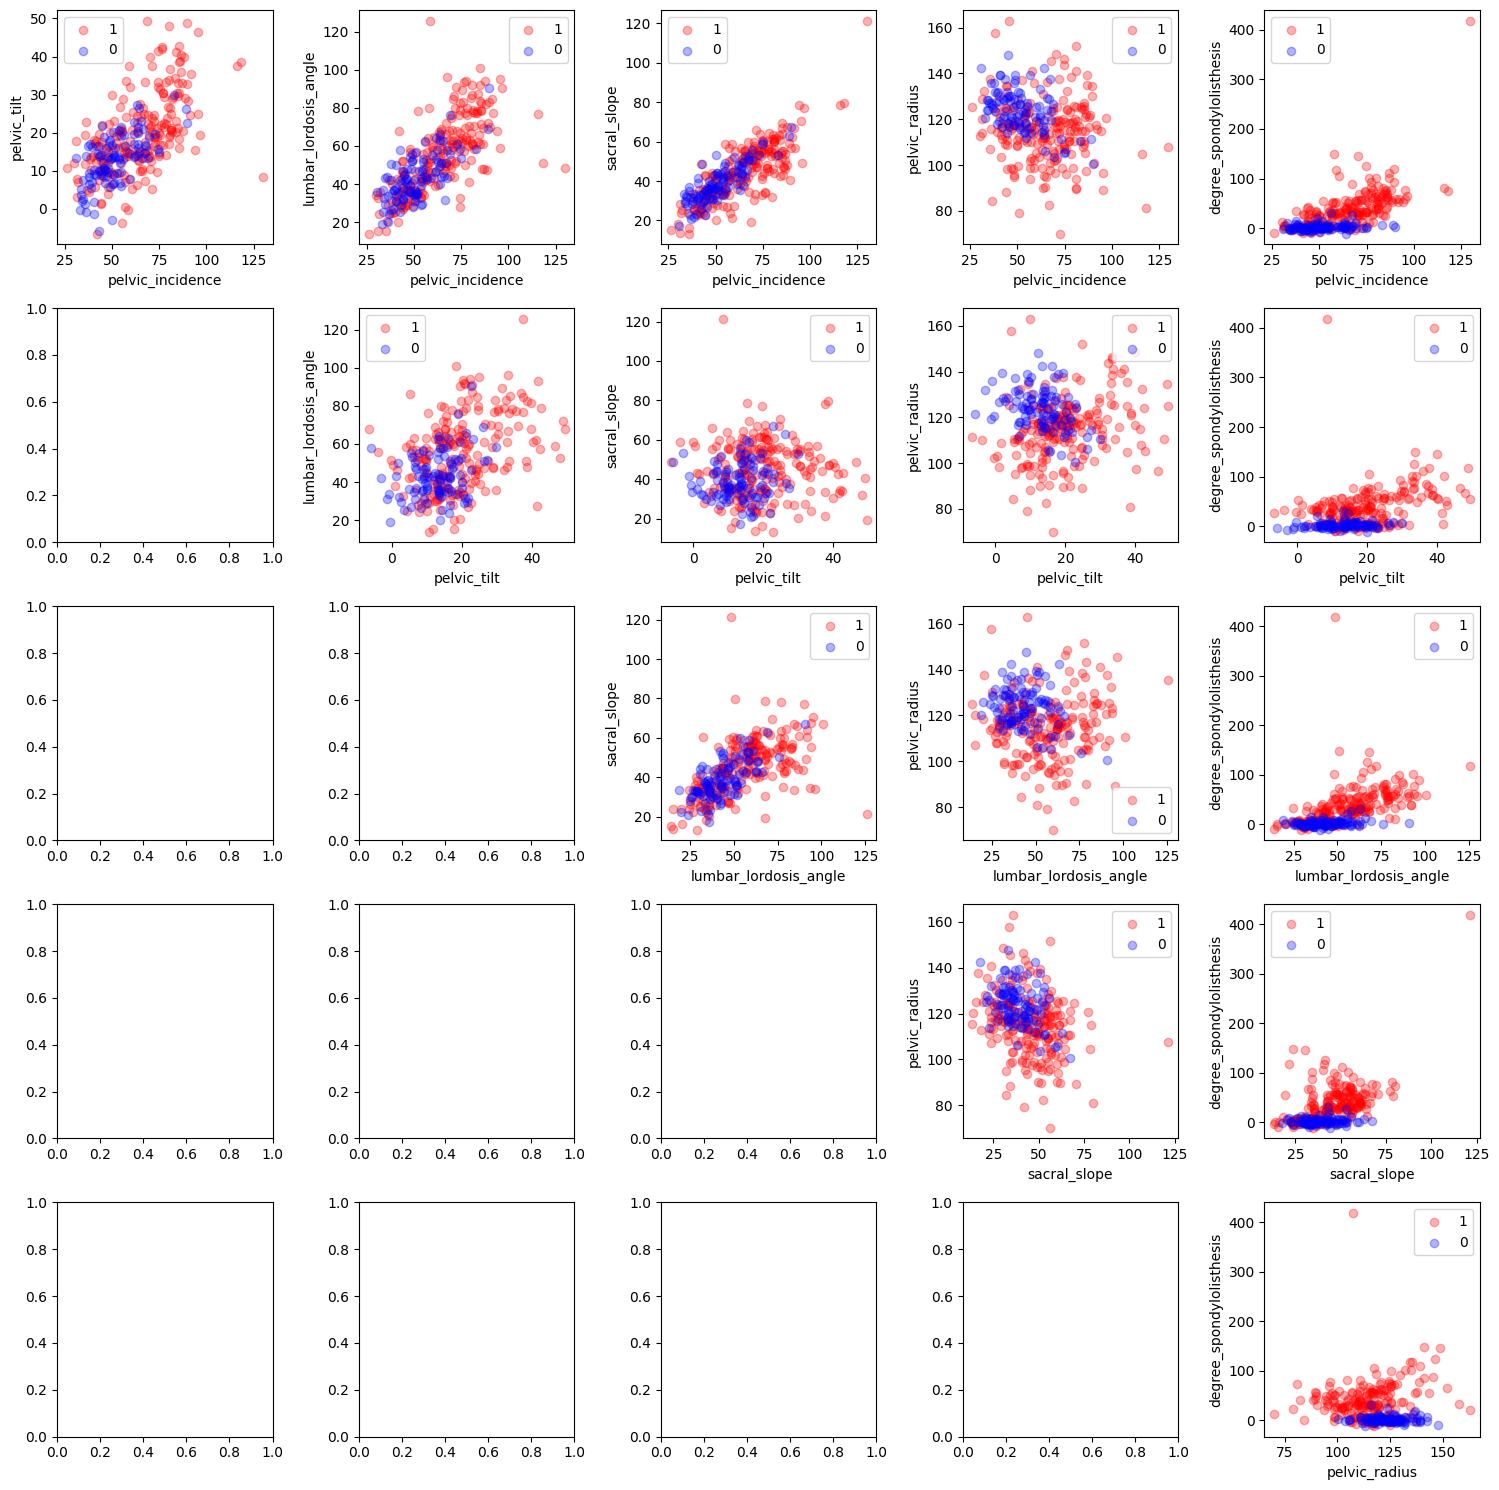

In [5]:
color_map= {1: 'red', 0: 'blue'}

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
#fig.title('Scatterplots of Independent Variables', fontsize = 16)

variables = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']

for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables[i+1:], start=i+1):
        ax = axes[i][j-1] if j > 0 else axes[j][i]  # assigning axes
        ax.scatter(subset_1[var1], subset_1[var2], c = color_map[1], label = 1, alpha=0.3)
        ax.scatter(subset_0[var1], subset_0[var2], c = color_map[0], label = 0, alpha=0.3)
        ax.set_xlabel(var1)
        ax.set_ylabel(var2)
        ax.legend()

plt.tight_layout()
plt.show()

#### ii) Below is the code that generates *boxplots* of independent variables in the dataset

Make boxplots for each of the independent variables. Use color to show Classes 0 and 1 (see ISLR p. 129).

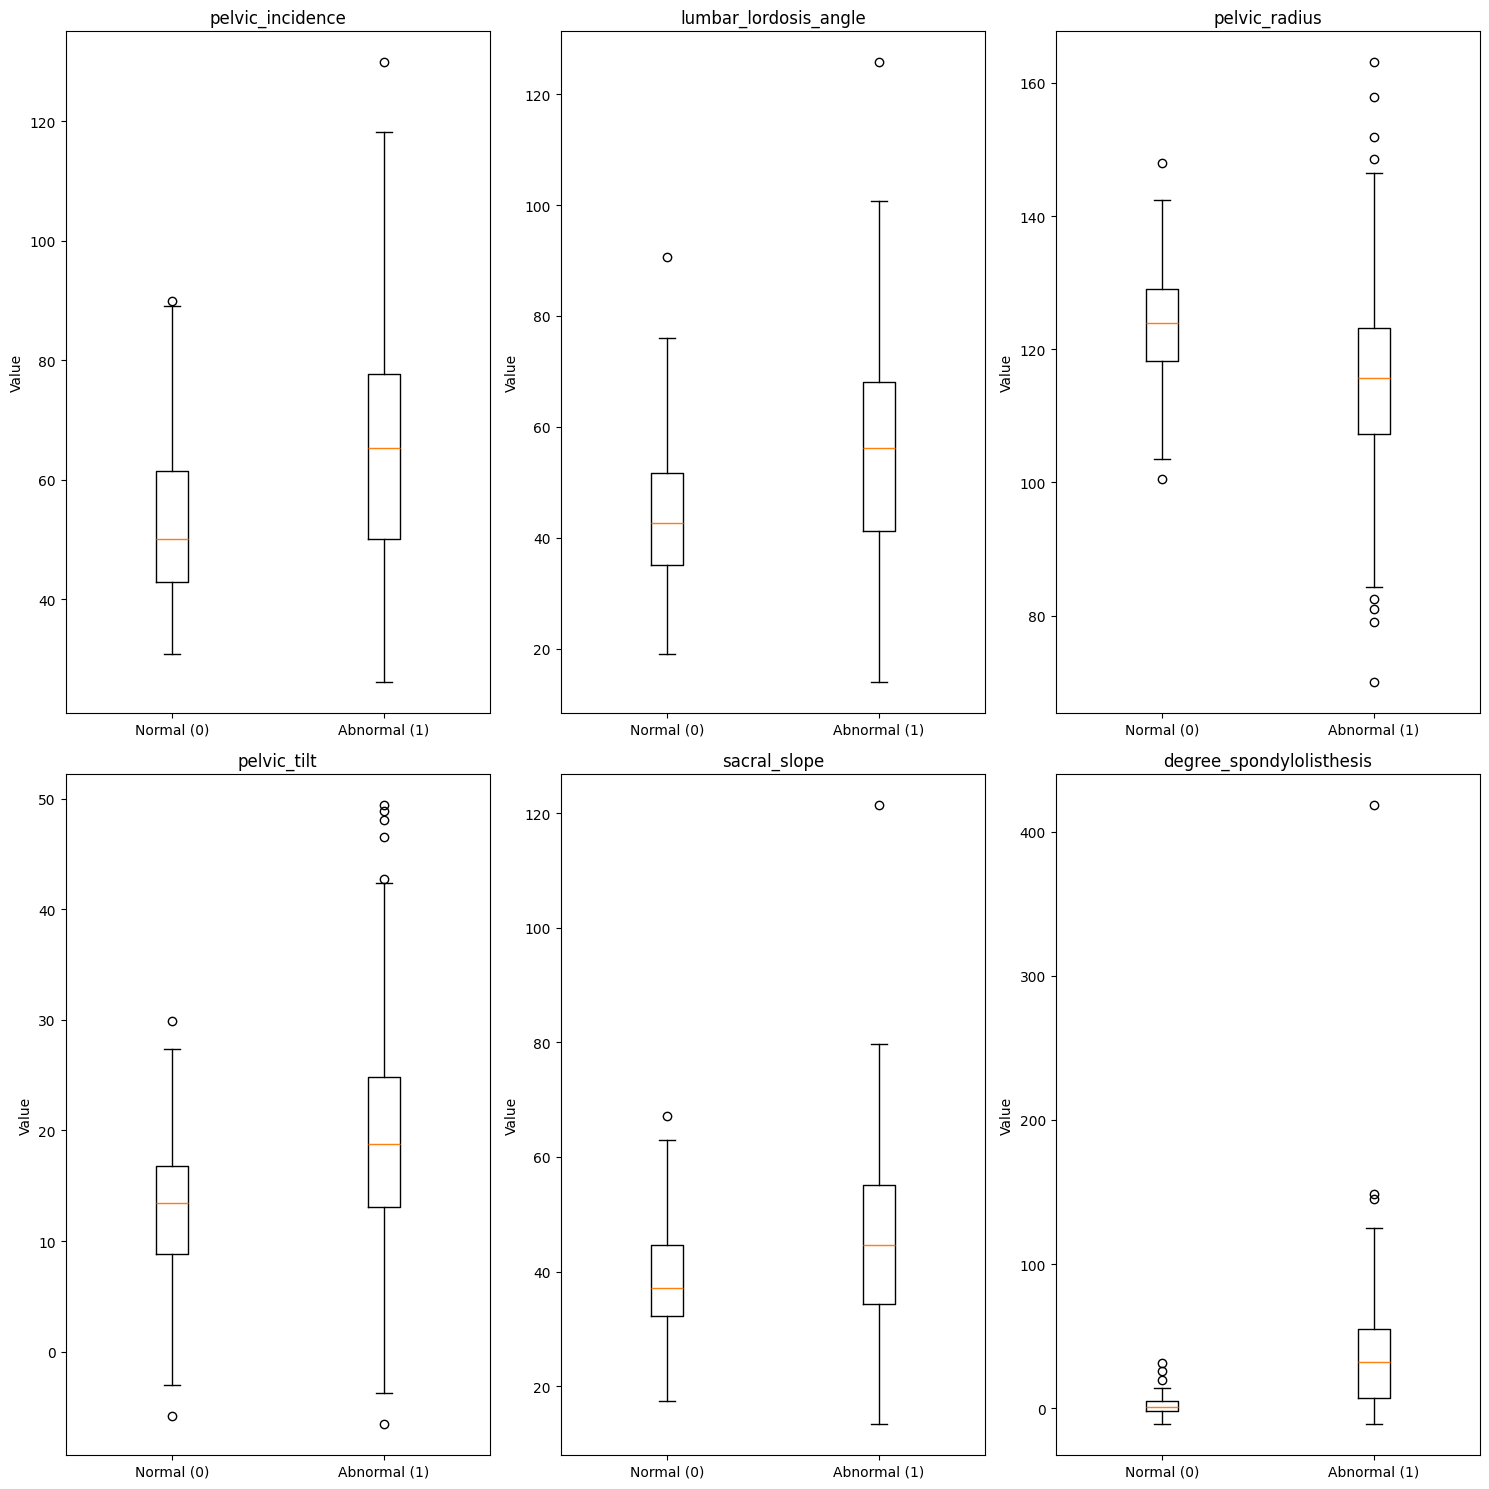

In [6]:
# color_map= {'Abnormal': 'red', 'Normal': 'blue'}

fig, axes = plt.subplots(2, 3, figsize=(15, 15))
#fig.title('Scatterplots of Independent Variables', fontsize = 16)

for i, var in enumerate(variables):
    row = i % 2
    col = i // 2

    boxplot = axes[row][col].boxplot([subset_0[var], subset_1[var]])
    
    axes[row][col].set_title(var)
    axes[row][col].set_xticklabels(['Normal (0)', 'Abnormal (1)'])
    axes[row][col].set_ylabel('Value')

plt.tight_layout()
plt.show()

#### iii) Dividing Training Set and Test Set

Select the ﬁrst 70 rows of Class 0 and the ﬁrst 140 rows of Class 1 as the training set and the rest of the data as the test set.

Because the rubrics has specifically stated the number of entries in the test and training set, we cannot use `train_test_split` in package `sklearn` directly

In [7]:
# Print shape of the original dataset
print("Original dataset: ", df.shape) 
print("Training set class distribution:", df.iloc[:,6].value_counts())

Original dataset:  (310, 7)
Training set class distribution: class
1    210
0    100
Name: count, dtype: int64


In [8]:
# Training set
dfTrain1 = subset_1.iloc[:140]
dfTrain0 = subset_0.iloc[:70]
dfTrain = pd.concat([dfTrain1, dfTrain0])

# Test set
dfTest1 = subset_1.iloc[140:]
dfTest0 = subset_0.iloc[70:]
dfTest = pd.concat([dfTest1, dfTest0])

# # deprecated: no need for shuffling
# # shuffle
# # Here I used Claude AI for help. In piazza someone said shuffling may result in a different best k values, so I decided to do a shuffle here.
# dfTrain = dfTrain.sample(frac=1, random_state=42).reset_index(drop=True)
# dfTest = dfTest.sample(frac=1, random_state=42).reset_index(drop=True)

# separate Xs and y
X_train = dfTrain.iloc[:,:6]
y_train = dfTrain.iloc[:, 6]
X_test = dfTest.iloc[:, :6]
y_test = dfTest.iloc[:, 6]

**Notes**：
I discovered that, with or without shuffling, the best for this dataset using Euclidean metric is 4 most of the time. The shuffling procedure has been commented out here so it won't affect the result.

In [9]:
# Print the shapes to verify
print("Training set shape:", X_train.shape)
print("Training set class distribution:", y_train.value_counts())
print("Test set shape:", X_test.shape)
print("Test set class distribution:", y_test.value_counts())

Training set shape: (210, 6)
Training set class distribution: class
1    140
0     70
Name: count, dtype: int64
Test set shape: (100, 6)
Test set class distribution: class
1    70
0    30
Name: count, dtype: int64


## c) Classification using KNN on Vertebral Column Data Set

#### i) KNN with Euclidean metric using `sklearn`


In [10]:
# scaling
# Reference on fit_transform vs transform: https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train(fit) the KNN model
k = 5   # tried 5 first
knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
knn.fit(X_train_scaled, y_train)
# Make predictions
y_pred = knn.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
conf_matrix = confusion_matrix(y_test, y_pred)
print("--------------------\nConfusion Matrix:")
print(conf_matrix)

Accuracy:  0.82
--------------------
Confusion Matrix:
[[16 14]
 [ 4 66]]


#### ii) Test and determine best k

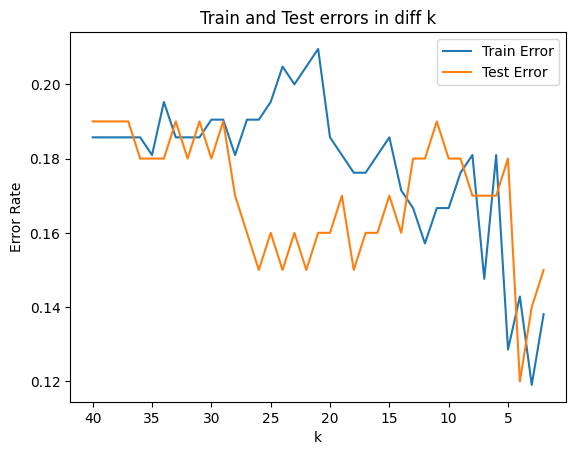

In [11]:
k_list = list(range(40, 1, -1))   # to get a closer look
# k_list = list(range(208, 1, -5))  # Uncomment this line to run as the rubric says

train_error = []
test_error = []
for k in k_list:
    # create and train
    knn = KNeighborsClassifier(n_neighbors=k,  metric = 'euclidean')
    knn.fit(X_train_scaled, y_train)
    # make pred
    y_train_pred = knn.predict(X_train_scaled)
    y_test_pred = knn.predict(X_test_scaled)

    # print/store error rates
    # print("error rate for training set", 1-accuracy_score(y_train, y_train_pred))
    # print("error rate for test set", 1-accuracy_score(y_test, y_test_pred))
    train_error.append(1-accuracy_score(y_train, y_train_pred))
    test_error.append(1-accuracy_score(y_test, y_test_pred))

BTE_Globel = min(train_error)   # for Question f

# visualise to see performance for different ks
plt.plot(k_list, train_error, label="Train Error")
plt.plot(k_list, test_error, label="Test Error")
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.title("Train and Test errors in diff k")
plt.gca().invert_xaxis()    # https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis
plt.legend()

I tried k = [1, 208] (inversely) with a step of 5 to see the error rate. I noticed that the error rate drops as the k gets smaller.
Therefore, I changed the range to [1, 40] (inversely) with a step of 1 to get a closer look, and for this shuffled dataset, **the best k value is 4**.

This can also be found using code:

In [12]:
# find best k
k_star = k_list[np.argmin(test_error)]  # the best k is found based on test set instead of training set
print(k_star)

# create and train best knn classifier
knn_star = KNeighborsClassifier(n_neighbors= k_star)
knn_star.fit(X_train_scaled, y_train)
y_pred = knn_star.predict(X_test_scaled)

4


Research on Calculating the confusion matrix, true positive rate, true negative rate, precision, and F1-score when k = k*:

[Reference Link](https://medium.com/analytics-vidhya/confusion-matrix-precision-recall-and-f1-score-d5f340e38cca)

In [13]:
# Calculations
confu_mx_auto = confusion_matrix(y_test, y_pred)
print(confu_mx_auto)

# manually calculate
tn, fp, fn, tp = 0, 0, 0, 0
for y, y_hat in zip(y_test, y_pred):
    if y==1 and y_hat==1:
        tp += 1
    elif y==0 and y_hat==0:
        tn += 1
    elif y==1 and y_hat==0:
        fn += 1
    elif y==0 and y_hat==1:
        fp += 1

# should be same as using sklearn pkg result
print("--------------------------\nConfusion Matrix: \n", np.array([[tn,fp], [fn,tp]]))      

# calculate true positive rate & true negative rate
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
print("--------------------------\n true positive rate: ", tpr)
print("--------------------------\n true negative rate: ", tnr)

# calculate precision
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("--------------------------\n precision: ", precision)

# calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print("--------------------------\n f1_score: ", f1_score)


[[22  8]
 [ 4 66]]
--------------------------
Confusion Matrix: 
 [[22  8]
 [ 4 66]]
--------------------------
 true positive rate:  0.9428571428571428
--------------------------
 true negative rate:  0.7333333333333333
--------------------------
 precision:  0.8918918918918919
--------------------------
 f1_score:  0.9166666666666667


#### iii) Learning Curve

Text(0.5, 1.0, 'Learning Curve')

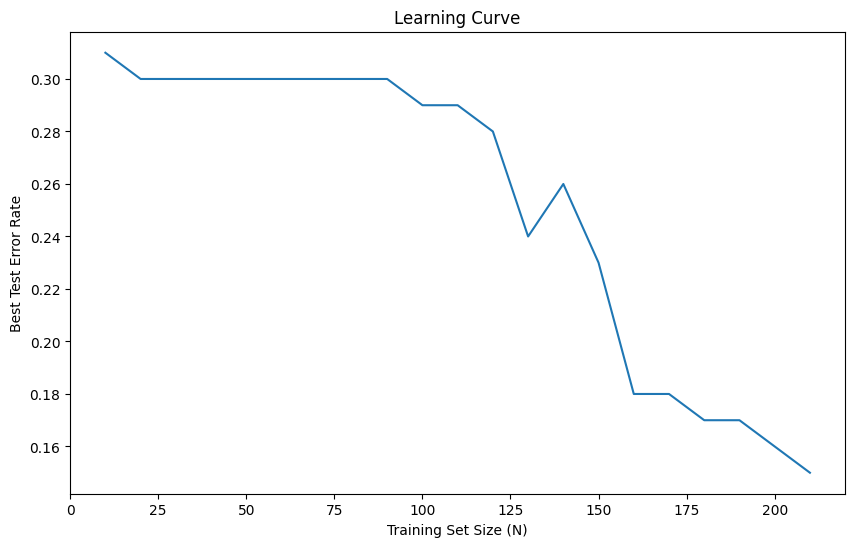

In [14]:
N_list = list(range(10, 211, 10))
best_test_errors = []

for N in N_list:
    n_class0 = N // 3       # 1/3 * N
    n_class1 = N - n_class0 # 2/3 * N
    
    # form subset of traning set
    subset_train = pd.concat([dfTrain0.iloc[:n_class0], dfTrain1.iloc[:n_class1]])
    X_subset = subset_train.iloc[:, :6]
    y_subset = subset_train['class']
    
    # start training and finding best k
    X_subset_scaled = scaler.fit_transform(X_subset)
    
    k_list_subset = list(range(1, N, 5))
    test_error_subset = []
    train_error_subset = []
    
    for k in k_list_subset:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_subset_scaled, y_subset)
        y_pred = knn.predict(X_test_scaled)
        test_error_subset.append(1 - accuracy_score(y_test, y_pred))

        # for Question f
        y_pred_train = knn.predict(X_subset_scaled)
        train_error_subset.append(1 - accuracy_score(y_subset, y_pred_train))
    
    best_test_errors.append(min(test_error_subset))
    
    BTE_temp = min(train_error_subset)
    BTE_Globel = BTE_temp if BTE_temp < BTE_Globel else BTE_Globel   # for Question f

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(N_list, best_test_errors)
plt.xlabel('Training Set Size (N)')
plt.ylabel('Best Test Error Rate')
plt.title('Learning Curve')

## d) Use other metric
* Minkowski Distance
* Manhattan Distance
* Chebyshev Distance
* Mahalanobis Distance

Did some search on different types of distance: [distance-metrics-and-k-nearest-neighbor-knn](https://medium.com/@luigi.fiori.lf0303/distance-metrics-and-k-nearest-neighbor-knn-1b840969c0f4)

In [15]:
# select k from {1, 6, 11, ..., 196}. It remains the same throughout Question d and e
k_list = list(range(1, 197, 5))     # 197 excluded

# define reusable function to find best k
# Using majority Polling
def find_best_k(X_train, y_train, X_test, y_test, metric, **kwargs):  # Reference on Python **kwargs: https://www.geeksforgeeks.org/args-kwargs-python/
    # store best k and lowest test error
    k_star = None
    best_test_error = float('inf')
    BTE = 1
    
    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric, **kwargs)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        test_error = 1 - accuracy_score(y_test, y_pred)
        if (test_error < best_test_error):
            best_test_error = test_error
            k_star = k

        # for question f
        y_pred_train = knn.predict(X_train)
        train_error = 1 - accuracy_score(y_train, y_pred_train) 
        BTE = train_error if train_error < BTE else BTE
    
    return k_star, best_test_error, BTE

#### i) Minkowski Distance

I used the sklearn pkg to calculate using different distance metrics: 

1. [sklearn Documentation Link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) <- Here it gives the link to all available distance metrics

2. [SciPy Documentation link](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

3. [sklearn Distance Metric](https://scikit-learn.org/0.24/modules/generated/sklearn.neighbors.DistanceMetric.html) <- Provided in the rubrics


In [16]:
results = {}

# A. Manhattan Distance (Minkowski with p=1)
k_star, error, BTE_manhattan = find_best_k(X_train_scaled, y_train, X_test_scaled, y_test, 'minkowski', p=1)
results['Manhattan'] = (k_star, error)

# for quetion f
BTE_Globel = BTE_manhattan if BTE_manhattan < BTE_Globel else BTE_Globel


# B. Minkowski Distance with different p values
p_list = [10**x for x in np.arange(0.1, 1.1, 0.1)]
minkowski_results = []
for p in p_list:
    _, error, BTE_Minkowski = find_best_k(X_train_scaled, y_train, X_test_scaled, y_test, 'minkowski', p=p)
    minkowski_results.append((p, error))
    # for quetion f
    BTE_Globel = BTE_Minkowski if BTE_Minkowski < BTE_Globel else BTE_Globel

best_p = min(minkowski_results, key=lambda x: x[1])[0]
min_error =  min(minkowski_results, key=lambda x: x[1])[1]
results[f'Minkowski(best_p={best_p:.2f}'] = (4, min_error)  # As previously found, k* = 4


# C. Chebyshev Distance (Minkowski with p→∞)
k_star, error, BTE_Chebyshev = find_best_k(X_train_scaled, y_train, X_test_scaled, y_test, 'chebyshev')    # no need to pass p value here
results['Chebyshev'] = (k_star, error)

# for quetion f
BTE_Globel = BTE_Chebyshev if BTE_Chebyshev < BTE_Globel else BTE_Globel


# result table
print("Metric                | Best k | Test Error")
print("----------------------|--------|------------")
for metric, (k, error) in results.items():
    print(f"{metric}             |   {k}    |   {error:.2f}")

Metric                | Best k | Test Error
----------------------|--------|------------
Manhattan             |   6    |   0.14
Minkowski(best_p=1.26             |   4    |   0.15
Chebyshev             |   1    |   0.15


As printed above, **best p is 1.26**. Therefore **the best log10(p)** = log10(1.26) = **0.1**

#### ii) Mahalanobis Distance

Reference: 

1. [How to pass params when doing KNN using Mahalanobis distance](https://github.com/yzhao062/pyod/blob/development/examples/knn_mahalanobis_example.py) <- line 41-43
(Thanks Prof Yue ZHAO 😄 It helped a lot)

2. [SciPy Doc for mahalanobis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html#scipy.spatial.distance.mahalanobis)

In [17]:
# calculate V / VI for Mahalanobis distance
# Reference: How to pass params from GitHub by Yue Zhao (link in the above md cell)

# deprecated
# I wrote it into a function, because xs & ys are also
# def mahalanobis_dist(x, y):
#     cov = np.cov(X_train_scaled.T)
#     inv_cov = np.linalg.inv(cov)
#     return mahalanobis(x, y, inv_cov)

X_train_cov = np.cov(X_train, rowvar=False)
X_train_inv_cov = np.linalg.inv(X_train_cov)
best_k, error, BTE_temp = find_best_k(X_train_scaled, y_train, X_test_scaled, y_test, 'mahalanobis', metric_params={'VI': X_train_inv_cov})
results['Mahalanobis'] = (best_k, error)

# for question f
BTE_Globel = BTE_temp if BTE_temp < BTE_Globel else BTE_Globel

# result table
print("Metric                | Best k | Test Error")
print("----------------------|--------|------------")
for metric, (k, error) in results.items():
    print(f"{metric}             |   {k}    |   {error:.2f}")

Metric                | Best k | Test Error
----------------------|--------|------------
Manhattan             |   6    |   0.14
Minkowski(best_p=1.26             |   4    |   0.15
Chebyshev             |   1    |   0.15
Mahalanobis             |   31    |   0.29


## e) Use Weighted Decision
instead of majority polling/voting

In [18]:
# define reusable function to find best k Using Weighted Decision
# I basically just made minor changes from function find_best_k: 
#       add an arg "weights"
def find_best_k_weighted(X_train, y_train, X_test, y_test, metric, **kwargs):
    # store best k and lowest test error
    k_star = None
    best_test_error = float('inf')
    BTE = 1
    
    for k in k_list:
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights='distance', **kwargs)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        test_error = 1 - accuracy_score(y_test, y_pred)
        if (test_error < best_test_error):
            best_test_error = test_error
            k_star = k

        # for question f
        y_pred_train = knn.predict(X_train)
        train_error = 1 - accuracy_score(y_train, y_pred_train) 
        BTE = train_error if train_error < BTE else BTE
    
    return k_star, best_test_error, BTE

In [19]:
metrics = ['euclidean', 'manhattan', 'chebyshev']
results = {} # clear prev results

for metric in metrics:
    best_k, error, BTE_temp = find_best_k_weighted(X_train_scaled, y_train, X_test_scaled, y_test, metric)
    results[metric] = (best_k, error)
    # for question f
    BTE_Globel = BTE_temp if BTE_temp < BTE_Globel else BTE_Globel

# Print results table
print("Metric    | Best k | Test Error")
print("----------|--------|------------")
for metric, (k, error) in results.items():
    print(f"{metric} |   {k}   |   {error:.2f}")

Metric    | Best k | Test Error
----------|--------|------------
euclidean |   21   |   0.15
manhattan |   6   |   0.15
chebyshev |   1   |   0.15


## f) lowest training error rate

 In this hw, I only calculated the training error for *KNN with Euclidean metric and majority polling*. This minimum training error for that is:

In [20]:
# for train_err in train_error:
#     print(train_err)
min(train_error)

0.11904761904761907

### Further analysis on lowest training rate:

I added lines of code above to calculate traning error for every algorithm. A global variable called BTE_Global is used to store the lowest training error througout the hw.

**The lowest training rate is 0** as the code below shows:

In [21]:
BTE_Globel

0.0

## References

1. Generative AI used: *Claude.ai* -- [link](https://claude.ai/)
    
    The usage is written in the comments in the above code

2. StackOverflow: 
    * [How to invert the x or y axis](https://stackoverflow.com/questions/2051744/how-to-invert-the-x-or-y-axis)
    * [What is Python **kwargs?](https://www.geeksforgeeks.org/args-kwargs-python/)

3. [fit-transform vs transform](https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe)

4. [Confusion matrix, Precision , Recall and F1-Score](https://medium.com/analytics-vidhya/confusion-matrix-precision-recall-and-f1-score-d5f340e38cca)

5. Distance Metrics
    * [Different Distances](https://medium.com/@luigi.fiori.lf0303/distance-metrics-and-k-nearest-neighbor-knn-1b840969c0f4)
    
    * [sklearn Doc for KNeighborClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) <- Here it gives the link to all available distance metrics

    * [sklearn Distance Metric](https://scikit-learn.org/0.24/modules/generated/sklearn.neighbors.DistanceMetric.html) <- Provided in the rubrics

    * [SciPy Doc for distance](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)
    
    * [SciPy Doc for mahalanobis distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html#scipy.spatial.distance.mahalanobis)

    * [How to pass params when doing KNN with Mahalanobis distance： An Example](https://github.com/yzhao062/pyod/blob/development/examples/knn_mahalanobis_example.py) <- line 41-43

